<a href="https://colab.research.google.com/github/AiNguyen2014/MachineLearningProject/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


LƯU Ý QUAN TRỌNG:
- Unsupervised learning KHÔNG có train/test split
- Toàn bộ 72 samples được cluster cùng lúc
- "Independent" chỉ là tên file, KHÔNG phải tập test

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

TARGET_FOLDER = "Project Machine Learning"
BASE_PATH = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if TARGET_FOLDER in dirs:
        BASE_PATH = os.path.join(root, TARGET_FOLDER)
        break

if BASE_PATH is None:
    raise FileNotFoundError(" Không tìm thấy thư mục Project Machine Learning")

print(" Dùng thư mục:", BASE_PATH)
print(" File trong thư mục:", os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dùng thư mục: /content/drive/MyDrive/Project Machine Learning
 File trong thư mục: ['data_set_ALL_AML_train.csv', 'actual.csv', 'data_set_ALL_AML_independent.csv', 'train_scaled.csv', 'test_scaled.csv', 'train_processed.csv', 'test_processed.csv', 'data_processed_72_variance.csv', 'data_processed_optimal.csv', 'data_final_processed.csv', 'AML&ALL.csv', 'data_processed_72.csv', 'Machine Learning.ipynb']


# Setup môi trường

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
from sklearn.decomposition import PCA
import joblib
warnings.filterwarnings('ignore')

# Tải dữ liệu

In [ ]:
# Train & Independent: gene là index
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_train.csv"),
    index_col=0
)

df_test = pd.read_csv(
    os.path.join(BASE_PATH, "data_set_ALL_AML_independent.csv"),
    index_col=0
)

df_actual = pd.read_csv(
    os.path.join(BASE_PATH, "actual.csv")
)

print("Train shape:", df_train.shape)
print("Independent shape:", df_test.shape)
print("Actual shape:", df_actual.shape)

Train shape: (7129, 77)
Independent shape: (7129, 69)
Actual shape: (72, 2)


Số mẫu tập huấn luyện: 38
Số mẫu tập độc lập: 34
Số gene sử dụng: 7129


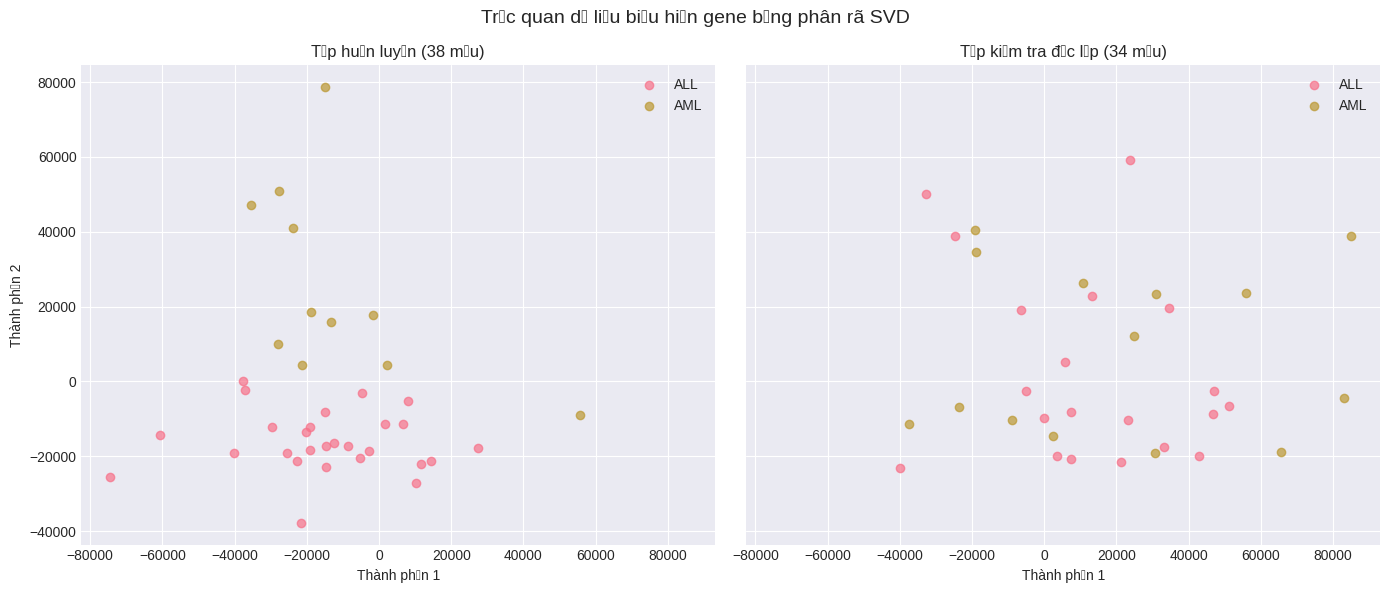

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def select_expression_columns(df):
    return [
        col for col in df.columns
        if "Gene Description" not in col
        and "Gene Accession Number" not in col
        and "call" not in col.lower()
    ]

# =============================
# CHỌN CỘT BIỂU HIỆN GENE
# =============================
train_cols = select_expression_columns(df_train)
test_cols  = select_expression_columns(df_test)

X_train = df_train[train_cols].T
X_test  = df_test[test_cols].T

print("Số mẫu tập huấn luyện:", X_train.shape[0])
print("Số mẫu tập độc lập:", X_test.shape[0])
print("Số gene sử dụng:", X_train.shape[1])

# =============================
# GỘP & CHIẾU XUỐNG 2 CHIỀU BẰNG SVD
# =============================
X_all = np.vstack([X_train.values, X_test.values])

# Chuẩn hoá trung bình
X_centered = X_all - X_all.mean(axis=0)

# Phân rã SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Lấy 2 thành phần chính
X_all_2d = U[:, :2] @ np.diag(S[:2])

# Tách lại train / test
X_train_2d = X_all_2d[:38]
X_test_2d  = X_all_2d[38:]

# =============================
# NHÃN THỰC TẾ (CHỈ DÙNG ĐỂ TÔ MÀU)
# =============================
labels = df_actual["cancer"].values
labels_train = labels[:38]
labels_test  = labels[38:]

# =============================
# TRỰC QUAN
# =============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Tập huấn luyện
axes[0].scatter(
    X_train_2d[labels_train == "ALL", 0],
    X_train_2d[labels_train == "ALL", 1],
    label="ALL",
    alpha=0.7
)
axes[0].scatter(
    X_train_2d[labels_train == "AML", 0],
    X_train_2d[labels_train == "AML", 1],
    label="AML",
    alpha=0.7
)
axes[0].set_title("Tập huấn luyện (38 mẫu)")
axes[0].set_xlabel("Thành phần 1")
axes[0].set_ylabel("Thành phần 2")
axes[0].legend()
axes[0].grid(True)

# Tập độc lập
axes[1].scatter(
    X_test_2d[labels_test == "ALL", 0],
    X_test_2d[labels_test == "ALL", 1],
    label="ALL",
    alpha=0.7
)
axes[1].scatter(
    X_test_2d[labels_test == "AML", 0],
    X_test_2d[labels_test == "AML", 1],
    label="AML",
    alpha=0.7
)
axes[1].set_title("Tập kiểm tra độc lập (34 mẫu)")
axes[1].set_xlabel("Thành phần 1")
axes[1].legend()
axes[1].grid(True)

plt.suptitle(
    "Trực quan dữ liệu biểu hiện gene bằng phân rã SVD",
    fontsize=14
)
plt.tight_layout()
plt.show()

# Tiền Xử Lý Dữ Liệu (Clean + Transpose + Z-score + Feature Selection)

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

def clean_gene_expression(df):
    drop_cols = [
        col for col in df.columns
        if "Gene Description" in col
        or "Gene Accession Number" in col
        or "call" in col.lower()
    ]
    return df.drop(columns=drop_cols, errors="ignore")


df_train_clean = clean_gene_expression(df_train)
df_test_clean  = clean_gene_expression(df_test)

X_train_raw = df_train_clean.T
X_test_raw  = df_test_clean.T


X_all_raw = pd.concat([X_train_raw, X_test_raw], axis=0)

print("Total samples after merge:", X_all_raw.shape)

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_raw)

print("Scaled shape:", X_all_scaled.shape)

N_GENES = 100

gene_variances = np.var(X_all_scaled, axis=0)

top_gene_idx = np.argsort(gene_variances)[-N_GENES:]
X_all_fs = X_all_scaled[:, top_gene_idx]

print(f"Selected top {N_GENES} genes (unsupervised)")
print("After FS shape:", X_all_fs.shape)

gene_cols = [f"Gene_{i+1}" for i in top_gene_idx]

X_all_out = pd.DataFrame(
    X_all_fs,
    index=X_all_raw.index,
    columns=gene_cols
)
X_all_out.insert(0, "Sample_ID", X_all_out.index)

X_all_out.to_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv"),
    index=False
)

print("\nPREPROCESSING COMPLETE")
print("Saved to: data_processed_72.csv", X_all_fs.shape)

Total samples after merge: (72, 7129)
Scaled shape: (72, 7129)
Selected top 100 genes (unsupervised)
After FS shape: (72, 100)

PREPROCESSING COMPLETE
Saved to: data_processed_72.csv (72, 100)


Trực quan dữ liệu đã được xử lý

Processed shape: (72, 100)
Labels shape: (72,)
Tỷ lệ phương sai: [0.14833381 0.13445772]
Tổng phương sai: 0.28279152356516735


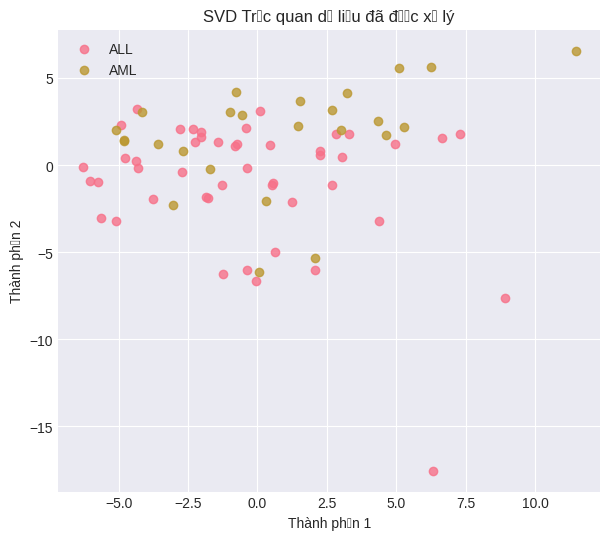

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# =============================
# LOAD DATA
# =============================
df_processed = pd.read_csv(
    os.path.join(BASE_PATH, "data_processed_72.csv")
)

X = df_processed.drop(columns=["Sample_ID"]).values

labels_text = df_actual["cancer"].values
labels_num = np.where(labels_text == "ALL", 0, 1)

print("Processed shape:", X.shape)
print("Labels shape:", labels_text.shape)

# =============================
# SVD PROJECTION (PCA-equivalent)
# =============================
# Center dữ liệu
X_centered = X - X.mean(axis=0)

# SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Lấy 2 thành phần đầu
X_svd = U[:, :2] @ np.diag(S[:2])

# Tỷ lệ phương sai (giống PCA)
explained_variance_ratio = (S**2) / np.sum(S**2)
print("Tỷ lệ phương sai:", explained_variance_ratio[:2])
print("Tổng phương sai:", explained_variance_ratio[:2].sum())

# =============================
# VISUALIZATION
# =============================
plt.figure(figsize=(7, 6))

plt.scatter(
    X_svd[labels_num == 0, 0],
    X_svd[labels_num == 0, 1],
    label="ALL",
    alpha=0.8
)

plt.scatter(
    X_svd[labels_num == 1, 0],
    X_svd[labels_num == 1, 1],
    label="AML",
    alpha=0.8
)

plt.xlabel("Thành phần 1")
plt.ylabel("Thành phần 2")
plt.title("SVD Trực quan dữ liệu đã được xử lý")
plt.legend()
plt.grid(True)
plt.show()


# BASE MODELS - K-MEANS++

## Import thư viện cần thiết

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load dữ liệu đã chuẩn hóa

In [ ]:
# Đọc dữ liệu train đã được chuẩn hóa
try:
    train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
    train_df = pd.read_csv(train_path)
    print(f"Đã tải dữ liệu Train từ: {train_path}")
except Exception as e:
    print(f"Lỗi tải file: {e}")
    exit()

# Bỏ cột định danh không phải feature nếu tồn tại
if 'Sample_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Sample_ID'])

# Chuyển thành numpy array
X_train = train_df.values  # hoặc train_df.to_numpy()


Đã tải dữ liệu Train từ: /content/drive/MyDrive/Project Machine Learning/data_processed_72.csv


In [ ]:
# Chuyển đổi DataFrame sang numpy array để tính toán
X = train_df.values
print(f"\nMảng dữ liệu X có shape: {X.shape}")


Mảng dữ liệu X có shape: (72, 100)


## Định nghĩa các hàm tính khoảng cách và inertia trong K means++

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def calculate_inertia(X, labels, centroids):
    return sum(
        np.sum((X[labels == i] - centroids[i]) ** 2)
        for i in range(len(centroids))
    )

In [ ]:
def kmeans_plusplus(X, k, max_iters=100, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    n = X.shape[0]

    # --- Khởi tạo centroids (K-Means++) ---
    centroids = [X[np.random.randint(n)]]
    for _ in range(1, k):
        dist = np.min(
            np.array([[euclidean_distance(x, c) for c in centroids] for x in X]),
            axis=1
        )
        probs = dist**2 / np.sum(dist**2)
        centroids.append(X[np.random.choice(n, p=probs)])
    centroids = np.array(centroids)

    # --- Iterative optimization ---
    for _ in range(max_iters):
        labels = np.argmin(
            np.linalg.norm(X[:, None] - centroids[None, :], axis=2),
            axis=1
        )
        new_centroids = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids

    return labels, centroids


## BƯỚC 1: ĐÁNH GIÁ & LỰA CHỌN SỐ CỤM K TỐI ƯU
**Thực hiện:** Chạy K-means++ với K từ 2 đến 10, so sánh Silhouette Score, chọn K tốt nhất

In [ ]:
print("=== CHỌN K BẰNG SILHOUETTE ===")
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    labels, _ = kmeans_plusplus(X, k)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"K={k}: Silhouette={sil:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"\n→ Chọn K tối ưu = {best_k}")

=== CHỌN K BẰNG SILHOUETTE ===
K=2: Silhouette=0.0908
K=3: Silhouette=0.0464
K=4: Silhouette=0.0468
K=5: Silhouette=0.0480
K=6: Silhouette=0.0617
K=7: Silhouette=0.0657
K=8: Silhouette=0.0683
K=9: Silhouette=0.0611
K=10: Silhouette=0.0220

→ Chọn K tối ưu = 2


In [ ]:
labels_final, centroids_final = kmeans_plusplus(X, best_k)

## ĐÁNH GIÁ KẾT QUẢ MÔ HÌNH TRÊN DỮ LIỆU TRAIN

In [ ]:
final_sil = silhouette_score(X, labels_final)
final_inertia = calculate_inertia(X, labels_final, centroids_final)

print("\n=== ĐÁNH GIÁ K-MEANS++ ===")
print(f"Số mẫu: {X.shape[0]}")
print(f"Số chiều: {X.shape[1]}")
print(f"Số cụm (K): {best_k}")
print(f"Silhouette Score: {final_sil:.4f}")
print(f"Inertia (SSE): {final_inertia:.2f}")

print("\nPhân bố cụm:")
for i in range(best_k):
    print(f"  Cụm {i}: {(labels_final == i).sum()} samples")


=== ĐÁNH GIÁ K-MEANS++ ===
Số mẫu: 72
Số chiều: 100
Số cụm (K): 2
Silhouette Score: 0.0908
Inertia (SSE): 6462.55

Phân bố cụm:
  Cụm 0: 35 samples
  Cụm 1: 37 samples


# BASE MODELS - HIERARCHICAL

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import os

# ============================================================
# PHẦN 1: BASE LEARNER - HIERARCHICAL CLUSTERING
# ============================================================

class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _compute_distance_matrix(self, X):
        n = X.shape[0]
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = self._euclidean_distance(X[i], X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

    # --- Linkage Functions ---
    def _single_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        min_dist = float('inf')
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] < min_dist: min_dist = dist_matrix[i, j]
        return min_dist

    def _complete_linkage(self, c1_idxs, c2_idxs, dist_matrix):
        max_dist = 0
        for i in c1_idxs:
            for j in c2_idxs:
                if dist_matrix[i, j] > max_dist: max_dist = dist_matrix[i, j]
        return max_dist

    def _ward_linkage(self, c1_idxs, c2_idxs, X):
        m1 = np.mean(X[c1_idxs], axis=0)
        m2 = np.mean(X[c2_idxs], axis=0)
        n1, n2 = len(c1_idxs), len(c2_idxs)
        return np.sqrt((2 * n1 * n2) / (n1 + n2)) * self._euclidean_distance(m1, m2)

    def _cluster_distance(self, c1_idxs, c2_idxs, dist_matrix, X):
        if self.linkage == 'single': return self._single_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'complete': return self._complete_linkage(c1_idxs, c2_idxs, dist_matrix)
        elif self.linkage == 'ward': return self._ward_linkage(c1_idxs, c2_idxs, X)

    def fit(self, X):
        n_samples = X.shape[0]
        clusters = {i: [i] for i in range(n_samples)}

        dist_matrix = None
        if self.linkage != 'ward':
            dist_matrix = self._compute_distance_matrix(X)

        while len(clusters) > self.n_clusters:
            min_dist = float('inf')
            merge_pair = None
            ids = list(clusters.keys())

            # Tìm cặp gần nhất
            for i in range(len(ids)):
                for j in range(i+1, len(ids)):
                    id1, id2 = ids[i], ids[j]
                    dist = self._cluster_distance(clusters[id1], clusters[id2], dist_matrix, X)
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (id1, id2)

            # Gộp
            c1, c2 = merge_pair
            new_id = max(ids) + 1
            clusters[new_id] = clusters[c1] + clusters[c2]
            del clusters[c1]; del clusters[c2]

        # Lưu nhãn cuối cùng
        self.labels_ = np.zeros(n_samples, dtype=int)
        for idx, (cid, members) in enumerate(clusters.items()):
            self.labels_[members] = idx
        return self

# ============================================================
# PHẦN 2: CHUẨN BỊ CHO ENSEMBLE (BASE LEARNERS)
# ============================================================

if __name__ == "__main__":
    # 1. Load Data
    try:
        train_path = os.path.join(BASE_PATH, 'data_processed_72.csv')
        train_df = pd.read_csv(train_path)
        X_train = train_df.drop('Sample_ID', axis=1, errors='ignore').values
        print(f" Đã tải dữ liệu: {X_train.shape}")
    except Exception as e:
        print(f"Lỗi: {e}"); exit()

    # 2. Tạo tập hợp các Base Learners (Đa dạng hóa bằng Linkage)
    # Lưu ý quan trọng: n_clusters=2 (Chuẩn bài toán ung thư)
    linkages = ['single', 'complete', 'ward']
    base_models = {}

    print("\n ĐANG XÂY DỰNG CÁC BASE LEARNERS...")

    for link in linkages:
        print(f"   -> Training {link.upper()} model...")
        model = HierarchicalClustering(n_clusters=2, linkage=link)
        model.fit(X_train)

        # Lưu model vào dictionary để dùng cho Ensemble sau này
        base_models[link] = model

        # Đánh giá nhanh chất lượng từng model con
        sil = silhouette_score(X_train, model.labels_)
        print(f"      (Silhouette: {sil:.4f})")

    print(f"\n Đã chuẩn bị xong {len(base_models)} mô hình cơ sở cho Ensemble!")
    print(f"   Danh sách: {list(base_models.keys())}")

 Đã tải dữ liệu: (72, 100)

 ĐANG XÂY DỰNG CÁC BASE LEARNERS...
   -> Training SINGLE model...
      (Silhouette: 0.4146)
   -> Training COMPLETE model...
      (Silhouette: 0.3872)
   -> Training WARD model...
      (Silhouette: 0.1596)

 Đã chuẩn bị xong 3 mô hình cơ sở cho Ensemble!
   Danh sách: ['single', 'complete', 'ward']


# BASE MODELS - GMM

Dataset shape: (72, 100)
Cluster labels: [1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1]

INTERNAL VALIDATION (GMM - 72 samples)
Silhouette: 0.1555
Davies–Bouldin: 2.8133


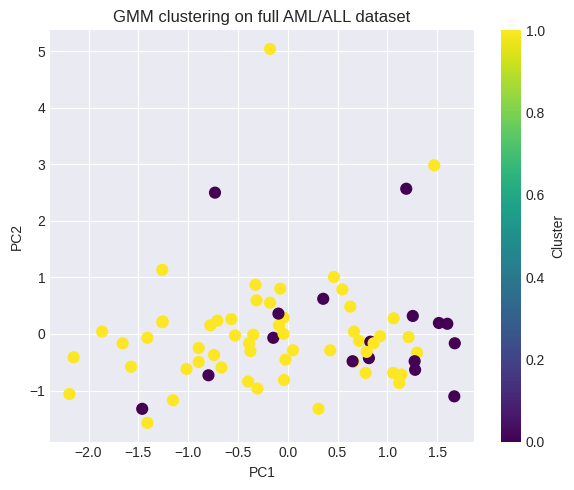

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import silhouette_score, davies_bouldin_score

# ============================================================
# LOAD DATA (72 samples - AFTER PREPROCESSING)
# ============================================================

df = pd.read_csv(os.path.join(BASE_PATH, "data_processed_72.csv"))
X = df.drop(columns=["Sample_ID"], errors="ignore").values

print("Dataset shape:", X.shape)


# ============================================================
# GMM WITH DIAGONAL COVARIANCE (STABLE VERSION)
# ============================================================

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, reg=1e-3):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg = reg

    def gaussian_diag(self, X, mean, var):
        d = X.shape[1]
        var = var + self.reg
        diff = X - mean
        log_prob = -0.5 * (
            np.sum(np.log(2 * np.pi * var)) +
            np.sum((diff ** 2) / var, axis=1)
        )
        return np.exp(log_prob)

    def fit(self, X):
        n, d = X.shape
        rng = np.random.default_rng(42)

        # Initialization
        self.means = X[rng.choice(n, self.K, replace=False)]
        self.vars = np.array([np.var(X, axis=0) for _ in range(self.K)])
        self.weights = np.ones(self.K) / self.K

        prev_ll = None

        for _ in range(self.max_iter):
            resp = np.zeros((n, self.K))

            # E-step
            for k in range(self.K):
                resp[:, k] = self.weights[k] * self.gaussian_diag(
                    X, self.means[k], self.vars[k]
                )

            resp_sum = resp.sum(axis=1, keepdims=True)
            resp_sum[resp_sum == 0] = 1e-10
            resp /= resp_sum

            Nk = resp.sum(axis=0)

            # M-step
            for k in range(self.K):
                self.means[k] = np.sum(resp[:, k][:, None] * X, axis=0) / Nk[k]
                diff = X - self.means[k]
                self.vars[k] = np.sum(resp[:, k][:, None] * (diff ** 2), axis=0) / Nk[k]
                self.weights[k] = Nk[k] / n

            ll = np.sum(np.log(resp_sum))
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            probs[:, k] = self.weights[k] * self.gaussian_diag(
                X, self.means[k], self.vars[k]
            )
        return np.argmax(probs, axis=1)


# ============================================================
# TRAIN GMM ON FULL DATASET
# ============================================================

gmm = GMM(n_components=2)
gmm.fit(X)

labels = gmm.predict(X)

print("Cluster labels:", labels)


# ============================================================
# INTERNAL VALIDATION
# ============================================================

sil = silhouette_score(X, labels)
db  = davies_bouldin_score(X, labels)

print("\nINTERNAL VALIDATION (GMM - 72 samples)")
print("Silhouette:", round(sil, 4))
print("Davies–Bouldin:", round(db, 4))


# ============================================================
# VISUALIZATION (PCA SPACE)
# ============================================================

X_vis = X[:, :2]

plt.figure(figsize=(6, 5))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap="viridis", s=60)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("GMM clustering on full AML/ALL dataset")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

gmm_labels_all = labels


# ENSEMBLE CLUSTERING

In [ ]:
import numpy as np
import pandas as pd
import os

def build_co_association_matrix(labels):
    n = len(labels)
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if labels[i] == labels[j]:
                C[i, j] = 1
    return C

try:
        path = os.path.join(BASE_PATH, 'data_processed_72.csv')
        df = pd.read_csv(train_path)
        X = df.drop(columns=["Sample_ID", "patient"], errors="ignore").values
        print(f" Đã tải dữ liệu: {X.shape}")
except Exception as e:
        print(f"Lỗi: {e}"); exit()

print("X shape:", X.shape)

labels_dict = {
    "kmeans": labels_final,
    "hierarchical": base_models["single"].labels_,
    "gmm": gmm_labels_all
}

weights = {
    "kmeans": 0.2,
    "hierarchical": 0.5,
    "gmm": 0.3
}
n = X.shape[0]
C_final = np.zeros((n, n))

for name, labels in labels_dict.items():
    C = build_co_association_matrix(labels)
    C_final += weights[name] * C

distance_matrix = 1 - C_final
def average_linkage_distance(cluster_a, cluster_b, dist_matrix):
    dists = []
    for i in cluster_a:
        for j in cluster_b:
            dists.append(dist_matrix[i, j])
    return np.mean(dists)


def hierarchical_consensus(dist_matrix, n_clusters=2):
    n = dist_matrix.shape[0]

    # mỗi sample là 1 cluster
    clusters = {i: [i] for i in range(n)}

    while len(clusters) > n_clusters:
        keys = list(clusters.keys())
        min_dist = float("inf")
        merge_pair = None

        # tìm cặp cluster gần nhất
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                c1 = clusters[keys[i]]
                c2 = clusters[keys[j]]
                d = average_linkage_distance(c1, c2, dist_matrix)
                if d < min_dist:
                    min_dist = d
                    merge_pair = (keys[i], keys[j])

        # gộp
        k1, k2 = merge_pair
        new_key = max(clusters.keys()) + 1
        clusters[new_key] = clusters[k1] + clusters[k2]
        del clusters[k1]
        del clusters[k2]

    # gán nhãn
    labels = np.zeros(n, dtype=int)
    for idx, members in enumerate(clusters.values()):
        labels[members] = idx

    return labels
ensemble_labels = hierarchical_consensus(distance_matrix, n_clusters=2)

 Đã tải dữ liệu: (72, 100)
X shape: (72, 100)


#  EVALUATION

In [ ]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
actual = pd.read_csv(os.path.join(BASE_PATH, "actual.csv"))

y_true = actual["cancer"].map({
    "ALL": 0,
    "AML": 1
}).values

def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency.values, axis=0)) / np.sum(contingency.values)

sil = silhouette_score(X, ensemble_labels)
db  = davies_bouldin_score(X, ensemble_labels)

print("\nINTERNAL EVALUATION (ENSEMBLE)")
print("Silhouette Score:", round(sil, 4))
print("Davies–Bouldin:", round(db, 4))
ari = adjusted_rand_score(y_true, ensemble_labels)
nmi = normalized_mutual_info_score(y_true, ensemble_labels)
pur = purity_score(y_true, ensemble_labels)

print("\nEXTERNAL EVALUATION (ENSEMBLE)")
print("ARI:", round(ari, 4))
print("NMI:", round(nmi, 4))
print("Purity:", round(pur, 4))


INTERNAL EVALUATION (ENSEMBLE)
Silhouette Score: 0.4146
Davies–Bouldin: 0.4385

EXTERNAL EVALUATION (ENSEMBLE)
ARI: -0.0129
NMI: 0.0166
Purity: 0.6528
